[Building powerful image classification using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [7]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('train/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (374, 500, 3)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 150, 150, 3)

# the .flow() command below generates batches of randomly transformed images and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

FileNotFoundError: [Errno 2] No such file or directory: 'train/cat.0.jpg'

In [8]:
# !rmdir /s /q preview
# !mkdir preview

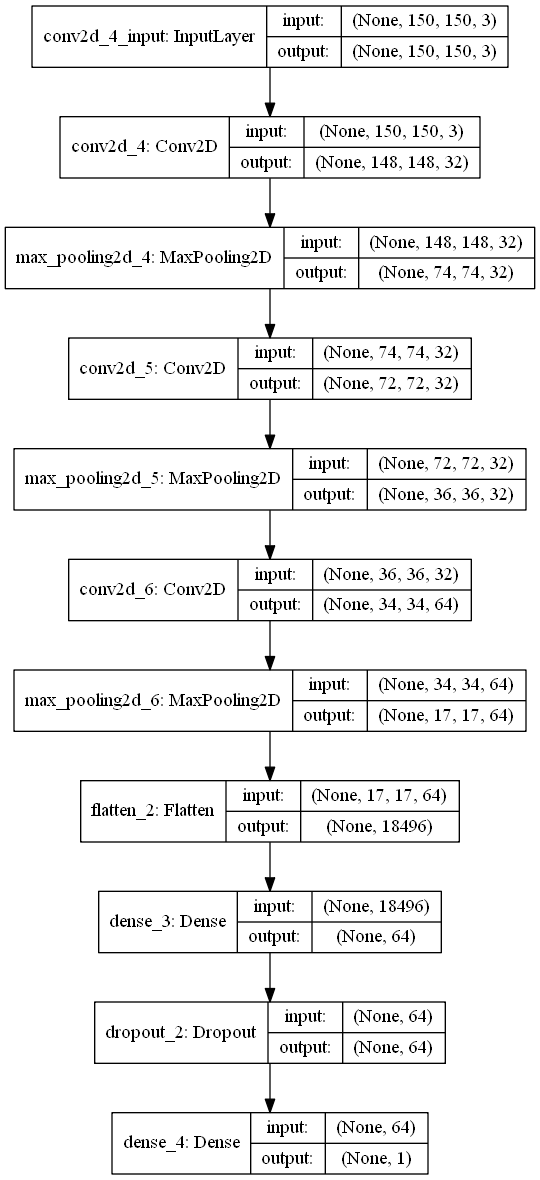

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3) , activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

keras.utils.plot_model(model, 'mini_cat_dog.png', show_shapes=True)

In [13]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing: only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [14]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/20


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_4/convolution (defined at C:\Users\Nehal\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_keras_scratch_graph_1933]

Function call stack:
keras_scratch_graph


# VGG16 - Fine Tuning the BottleNeck Features

In [ ]:
#
'''This script goes along the blog post
"Building powerful image classification models using very little data" from blog.keras.io.
It uses data that can be downloaded at: https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```
'''

In [85]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

In [86]:
# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [88]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)
    
save_bottlebeck_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [92]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)


# save_bottlebeck_features()
train_top_model()

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7614 - accuracy: 0.7570 - val_loss: 0.2593 - val_accuracy: 0.9013
Epoch 2/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3754 - accuracy: 0.8515 - val_loss: 0.4871 - val_accuracy: 0.7950
Epoch 3/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2981 - accuracy: 0.8865 - val_loss: 0.4317 - val_accuracy: 0.8263
Epoch 4/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2620 - accuracy: 0.8975 - val_loss: 0.2741 - val_accuracy: 0.8850
Epoch 5/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2348 - accuracy: 0.9080 - val_loss: 0.3804 - val_accuracy: 0.8675
Epoch 6/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2269 - accuracy: 0.9245 - val_loss: 0.4134 - val_accuracy: 0.8700
Epoch 7/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1745 - accu

## Fine Tunining

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import layers

tf.keras.backend.clear_session()

In [4]:
def toyResNet():
    inputs = keras.Input(shape=(150, 150,3), name='img')
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(232, 3, activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    block_3_output = layers.add([x, block_2_output])

    x = layers.Conv2D(64, 3, activation='relu')(block_3_output)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10)(x)

    model = keras.Model(inputs, outputs, name='toy_resnet')
    return model

model_t = toyResNet()
keras.utils.plot_model(model_t, 'mini_resnet.png', show_shapes=True)

AttributeError: 'tuple' object has no attribute 'layer'

In [107]:
inputs = keras.Input(shape=(150, 150, 3))

x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)


# the model so far outputs 3D feature maps (height, width, features)
x = layers.Flatten()(x)


x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

keras.utils.plot_model(model, 'mini_cat_dog.png', show_shapes=True)

AttributeError: 'tuple' object has no attribute 'layer'

In [59]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing: only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'sample_cat_dog_train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'sample_cat_dog_validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [60]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/20
125/125 [==============================] - 27s 214ms/step - loss: 0.6984 - accuracy: 0.5040 - val_loss: 0.6854 - val_accuracy: 0.5328
Epoch 2/20
125/125 [==============================] - 25s 198ms/step - loss: 0.6907 - accuracy: 0.5310 - val_loss: 0.6724 - val_accuracy: 0.5909
Epoch 3/20
125/125 [==============================] - 25s 199ms/step - loss: 0.6787 - accuracy: 0.5600 - val_loss: 0.6955 - val_accuracy: 0.6301
Epoch 4/20
125/125 [==============================] - 25s 201ms/step - loss: 0.6469 - accuracy: 0.6195 - val_loss: 0.6019 - val_accuracy: 0.5829
Epoch 5/20
125/125 [==============================] - 25s 197ms/step - loss: 0.6332 - accuracy: 0.6520 - val_loss: 0.6464 - val_accuracy: 0.5972
Epoch 6/20
125/125 [==============================] - 25s 197ms/step - loss: 0.6139 - accuracy: 0.6645 - val_loss: 0.5242 - val_accuracy: 0.6831
Epoch 7/20
125/125 [==============================] - 25s 199ms/step - loss: 0.5904 - accuracy: 0.6885 - val_loss: 0.4631 - val_ac

# VGG16 - Fine Tuning the BottleNeck Features

In [85]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

In [86]:
# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [88]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)
    
save_bottlebeck_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [92]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)


# save_bottlebeck_features()
train_top_model()

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7614 - accuracy: 0.7570 - val_loss: 0.2593 - val_accuracy: 0.9013
Epoch 2/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3754 - accuracy: 0.8515 - val_loss: 0.4871 - val_accuracy: 0.7950
Epoch 3/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2981 - accuracy: 0.8865 - val_loss: 0.4317 - val_accuracy: 0.8263
Epoch 4/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2620 - accuracy: 0.8975 - val_loss: 0.2741 - val_accuracy: 0.8850
Epoch 5/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2348 - accuracy: 0.9080 - val_loss: 0.3804 - val_accuracy: 0.8675
Epoch 6/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2269 - accuracy: 0.9245 - val_loss: 0.4134 - val_accuracy: 0.8700
Epoch 7/50
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1745 - accu